In [21]:
import warnings
import math

import numpy as np
import pandas as pd

from jre_utils.datapath import (
    factor_data_paths,
    model_ready_data_paths,
    get_price_index_path
)
from jre_utils.config import asset_types

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [22]:
dataset_asset_type = "combined"
dataset_key = "transactions"
years_ahead = 3

metrics = {
    "median": "unit_price_median",
    "gmean": "unit_price_gmean",
    "robust": "robust_price_index",
    "ols": "ols_price_index",
}

granularity_columns = ["area", "area_code"]
group_by_columns = granularity_columns + ["year"]

metric_key = "robust"
metric = metrics[metric_key]
metric_pct_chg = metric + "_pct_chg"
metric_sharpe = metric + "_sharpe"
normalized_metric_sharpe = metric_sharpe + "_normalized_yearly"

get_data_path = get_price_index_path


In [23]:
population_path = factor_data_paths["processed"]["population"]["municipality"]
migration_path = factor_data_paths["processed"]["migration"]["municipality"]
taxable_income_path = factor_data_paths["processed"]["taxable_income"]["municipality"]
new_dwellings_path = factor_data_paths["processed"]["new_dwellings"]["municipality"]
lfs_revenue_path = factor_data_paths["processed"]["lfs_revenue_breakdown"]["municipality"]

dataset_name = f"sequence_{dataset_key}_{dataset_asset_type}_{metric_key}_{years_ahead}"
model_ready_data_path = model_ready_data_paths[dataset_name]

In [24]:
# concat all asset types horizontally here
# Once creating time series dataset,
# create 3 datasets and concat them vertically
# To do that, loop 3 times with different metrics

In [25]:
id_columns = ["area_code", "area", "year"]

factor_log_normalize_columns = [
    "in_migrations",
    "out_migrations",
    "population",
    "taxpayer_count",
    "taxable_income",
    "taxable_income_per_taxpayer",
    "total_tax",
    "new_dwellings",
    "existing_dwellings",

    # Log normalizing seems to be good for everything!
    "total_tax_growth",
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "net_migration_ratio",
    "new_dwellings_ratio",
    "taxpayer_count_growth",
]

factor_normalize_columns = [
    "total_tax_growth",
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "net_migration_ratio",
    "new_dwellings_ratio",
    "taxpayer_count_growth",
]

factor_maintain_columns = [
    "migrations_is_available",
    "taxable_income_is_available",
    "dwellings_is_available",
    "total_tax_is_available",
]

factor_columns = (
    [f"{column}_log_normalized_yearly" for column in factor_log_normalize_columns]
    + [f"{column}_normalized_yearly" for column in factor_normalize_columns]
    + factor_maintain_columns
)

final_factor_columns = list(set(factor_normalize_columns + factor_log_normalize_columns + factor_columns))

In [26]:
core_log_normalize_columns = ["count", "yearly_price_growth"]
core_normalize_columns = [metric_sharpe]
core_maintain_columns = [metric, metric_sharpe, "metric_sharpe_is_available"]

core_columns = (
    [f"{column}_log_normalized_yearly" for column in core_log_normalize_columns]
    + [f"{column}_normalized_yearly" for column in core_normalize_columns]
    + core_maintain_columns
)

final_core_columns = list(set(core_normalize_columns + core_log_normalize_columns + core_columns))

combined_final_core_columns = [f"{asset_type}_{column}" for column in final_core_columns for asset_type in asset_types]

In [27]:
# combined_final_core_columns

In [28]:
final_columns = id_columns + combined_final_core_columns + final_factor_columns

In [29]:
# Tests

df = pd.read_csv(get_data_path("building"))
df = df.sort_values(by=group_by_columns, ascending=True)
df = df[group_by_columns + [metric]]

# prepare additional factors
df["yearly_price_growth"] = df.groupby(granularity_columns)[metric].pct_change()
df["log_yearly_price_growth"] = np.log(1 + df["yearly_price_growth"])

# prepare main metrics
df[metric_pct_chg] = df.groupby(granularity_columns)[metric].pct_change(
    periods=years_ahead
)

epsilon = math.pow(10, max(-3, -years_ahead))
# epsilon = math.exp(max(-3, -years_ahead))
df[metric_sharpe] = df.groupby(granularity_columns)[
    "log_yearly_price_growth"
].transform(lambda x: x.rolling(years_ahead).mean() / (x.rolling(years_ahead).std() + epsilon))

<Axes: ylabel='Frequency'>

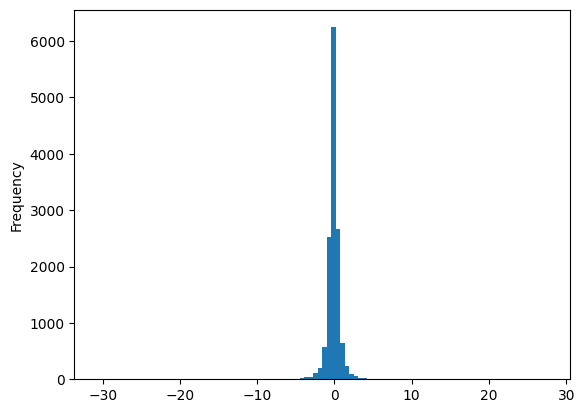

In [30]:
df[metric_sharpe].plot.hist(bins=100)

<Axes: xlabel='robust_price_index_pct_chg', ylabel='robust_price_index_sharpe'>

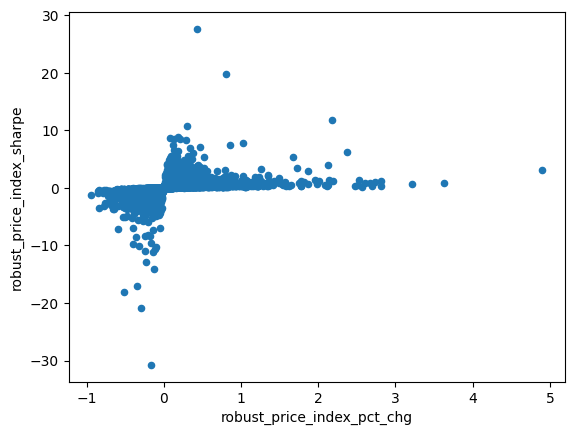

In [31]:
df.plot.scatter(x=metric_pct_chg, y=metric_sharpe)

In [32]:
import math


derived_dfs = {}

for asset_type in asset_types:
    df = pd.read_csv(get_data_path(asset_type))
    df = df.sort_values(by=group_by_columns, ascending=True)
    df = df[group_by_columns + [metric, "count", "robust_weights"]]

    # prepare main metric
    df["yearly_price_growth"] = df.groupby(granularity_columns)[metric].pct_change()
    df["log_yearly_price_growth"] = np.log(1 + df["yearly_price_growth"])

    epsilon = math.pow(10, max(-3, -years_ahead))
    
    df[metric_sharpe] = df.groupby(granularity_columns)[
        "log_yearly_price_growth"
    ].transform(
        lambda x: x.rolling(years_ahead).mean()
        / (x.rolling(years_ahead).std() + epsilon)
    )

    # prepare additional factors
    df["metric_sharpe_is_available"] = df[metric_sharpe].notnull().astype(int)

    for column in core_log_normalize_columns:
        df[f"{column}_log"] = df[column].apply(lambda x: np.log10(1 + x))
        df[f"{column}_log_normalized_yearly"] = df.groupby("year")[f"{column}_log"].transform(
            lambda x: (x - x.mean()) / x.std()
        )

    for column in core_normalize_columns:
        df[f"{column}_normalized_yearly"] = df.groupby("year")[column].transform(
            lambda x: (x - x.mean()) / x.std()
        )


    df = df[group_by_columns + final_core_columns]

    derived_dfs[asset_type] = df.rename(
        columns={column: f"{asset_type}_{column}" for column in final_core_columns}
    )

combined_derived_dfs = (
    derived_dfs["building"]
    .merge(
        derived_dfs["land"],
        on=["year", "area_code", "area"],
        how="outer",
    )
    .merge(
        derived_dfs["condo"],
        on=["year", "area_code", "area"],
        how="outer",
    )
)

In [33]:
df = combined_derived_dfs

population_df = pd.read_csv(population_path)
migration_df = pd.read_csv(migration_path)
taxable_income_df = pd.read_csv(taxable_income_path)
new_dwellings_df = pd.read_csv(new_dwellings_path)
lfs_revenue_df= pd.read_csv(lfs_revenue_path)

df = (
    df.merge(population_df, on=group_by_columns, how="left")
    .merge(migration_df, on=group_by_columns, how="left")
    .merge(taxable_income_df, on=group_by_columns, how="left")
    .merge(new_dwellings_df, on=group_by_columns, how="left")
    .merge(lfs_revenue_df, on=group_by_columns, how="left")
)

In [34]:
df["migrations_is_available"] = df["net_migration_ratio"].notnull().astype(int)
df["taxable_income_is_available"] = df["taxable_income"].notnull().astype(int)
df["total_tax_is_available"] = df["total_tax"].notnull().astype(int)
df["dwellings_is_available"] = df["new_dwellings"].notnull().astype(int)

In [35]:
df = df[final_columns]

In [36]:
df.to_csv(model_ready_data_path, index=False)

In [37]:
df.describe()

area_code          year  land_count_log_normalized_yearly  \
count  19269.000000  19269.000000                      1.870900e+04   
mean   21813.182781   2014.824589                     -1.701444e-16   
std    13413.327988      4.441984                      9.995723e-01   
min     1100.000000   2006.000000                     -3.245062e+00   
25%    11221.000000   2011.000000                     -7.296904e-01   
50%    21208.000000   2015.000000                     -6.852297e-02   
75%    32206.000000   2019.000000                      6.464501e-01   
max    47362.000000   2022.000000                      3.676457e+00   

       building_count_log_normalized_yearly  \
count                          1.688000e+04   
mean                          -1.810032e-16   
std                            9.995259e-01   
min                           -2.584571e+00   
25%                           -7.444913e-01   
50%                           -1.310240e-01   
75%                            6.503679e-01   
max                            3.959137e+00   

       condo_count_log_normalized_yearly  land_robust_price_index  \
count                       4.733000e+03             18709.000000   
mean                       -1.441202e-16                80.687004   
std                         9.983080e-01                24.151981   
min                        -2.717833e+00                 7.792773   
25%                        -7.412944e-01                64.940613   
50%                        -1.221307e-01                79.795713   
75%                         6.048104e-01                94.993414   
max                         3.274027e+00               361.020339   

       building_robust_price_index  condo_robust_price_index  \
count                 16880.000000               4733.000000   
mean                     89.752148                117.185139   
std                      31.104802                 26.038730   
min                       7.168820                 51.426443   
25%                      75.442102                100.000000   
50%                      88.431567                110.447354   
75%                     100.000000                129.517434   
max                    1008.725270                331.894401   

       land_yearly_price_growth_log_normalized_yearly  \
count                                    1.748400e+04   
mean                                     2.438376e-18   
std                                      9.995709e-01   
min                                     -7.765857e+00   
25%                                     -4.159317e-01   
50%                                      2.805414e-02   
75%                                      4.327387e-01   
max                                      7.984195e+00   

       building_yearly_price_growth_log_normalized_yearly  \
count                                       1.576900e+04    
mean                                       -2.647244e-18    
std                                         9.995242e-01    
min                                        -8.861758e+00    
25%                                        -3.576866e-01    
50%                                         2.605424e-02    
75%                                         3.630593e-01    
max                                         1.018125e+01    

       condo_yearly_price_growth_log_normalized_yearly  \
count                                     4.423000e+03   
mean                                     -2.971974e-17   
std                                       9.983025e-01   
min                                      -6.354346e+00   
25%                                      -4.680405e-01   
50%                                       1.857667e-02   
75%                                       5.189448e-01   
max                                       7.021683e+00   

       land_metric_sharpe_is_available  building_metric_sharpe_is_available  \
count                     18709.000000                         16880.000000   
me

In [38]:
area_code = 1100
df[df["area_code"] == area_code][["year"] + [f"{asset_type}_{metric_sharpe}" for asset_type in asset_types]]

year  land_robust_price_index_sharpe  \
5110  2006                             NaN   
5111  2007                             NaN   
5112  2008                             NaN   
5113  2009                       -1.323479   
5114  2010                       -0.598576   
5115  2011                       -0.401818   
5116  2012                        0.291623   
5117  2013                        0.290241   
5118  2014                       -0.256298   
5119  2015                       -0.376016   
5120  2016                       -0.232654   
5121  2017                        0.642082   
5122  2018                        2.731215   
5123  2019                        1.469557   
5124  2020                        1.576353   
5125  2021                        1.419617   
5126  2022                        3.043488   

      building_robust_price_index_sharpe  condo_robust_price_index_sharpe  
5110                                 NaN                              NaN  
5111                                 NaN                              NaN  
5112                                 NaN                              NaN  
5113                           -1.298772                              NaN  
5114                           -0.605688                        -0.440875  
5115                           -0.508725                         0.236545  
5116                           -0.015078                         1.890780  
5117                            0.328220                         3.603650  
5118                           -0.046055                         9.365683  
5119                            0.242679                        12.669476  
5120                            0.416895                         7.583110  
5121                            1.979298                         3.499958  
5122                            3.721566                         1.677272  
5123                            4.005149                         2.855499  
5124                            3.827702                         3.706936  
5125                            1.657437                         1.529681  
5126                            1.901244                         2.064660

In [39]:
# loop

for years_ahead in range(2, 5):
    dataset_name = f"sequence_{dataset_key}_{dataset_asset_type}_{metric_key}_{years_ahead}"
    model_ready_data_path = model_ready_data_paths[dataset_name]
    
    derived_dfs = {}

    for asset_type in asset_types:
            df = pd.read_csv(get_data_path(asset_type))
            df = df.sort_values(by=group_by_columns, ascending=True)
            df = df[group_by_columns + [metric, "count", "robust_weights"]]

            # prepare main metric
            df["yearly_price_growth"] = df.groupby(granularity_columns)[metric].pct_change()
            df["log_yearly_price_growth"] = np.log(1 + df["yearly_price_growth"])

            epsilon = math.pow(10, max(-3, -years_ahead))
            df[metric_sharpe] = df.groupby(granularity_columns)[
                "log_yearly_price_growth"
            ].transform(
                lambda x: x.rolling(years_ahead).mean()
                / (x.rolling(years_ahead).std() + epsilon)
            )

            # prepare additional factors
            df["metric_sharpe_is_available"] = df[metric_sharpe].notnull().astype(int)

            for column in core_log_normalize_columns:
                df[f"{column}_log"] = df[column].apply(lambda x: np.log10(1 + x))
                df[f"{column}_log_normalized_yearly"] = df.groupby("year")[f"{column}_log"].transform(
                    lambda x: (x - x.mean()) / x.std()
                )

            for column in core_normalize_columns:
                df[f"{column}_normalized_yearly"] = df.groupby("year")[column].transform(
                    lambda x: (x - x.mean()) / x.std()
                )


            df = df[group_by_columns + final_core_columns]

            derived_dfs[asset_type] = df.rename(
                columns={column: f"{asset_type}_{column}" for column in final_core_columns}
            )

    df = (
        derived_dfs["building"].merge(
            derived_dfs["land"],
            on=["year", "area_code", "area"],
            how="outer",
        ).merge(
            derived_dfs["condo"],
            on=["year", "area_code", "area"],
            how="outer",
        )
    )

    population_df = pd.read_csv(population_path)
    migration_df = pd.read_csv(migration_path)
    taxable_income_df = pd.read_csv(taxable_income_path)
    new_dwellings_df = pd.read_csv(new_dwellings_path)
    lfs_revenue_df= pd.read_csv(lfs_revenue_path)

    df = (
        df.merge(population_df, on=group_by_columns, how="left")
        .merge(migration_df, on=group_by_columns, how="left")
        .merge(taxable_income_df, on=group_by_columns, how="left")
        .merge(new_dwellings_df, on=group_by_columns, how="left")
        .merge(lfs_revenue_df, on=group_by_columns, how="left")
    )

    df["migrations_is_available"] = df["net_migration_ratio"].notnull().astype(int)
    df["taxable_income_is_available"] = df["taxable_income"].notnull().astype(int)
    df["total_tax_is_available"] = df["total_tax"].notnull().astype(int)
    df["dwellings_is_available"] = df["new_dwellings"].notnull().astype(int)

    df.to_csv(model_ready_data_path, index=False)
